In [2]:
import os
from os import listdir
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mne.decoding import CSP


In [3]:
# list all the subject wise csv files
def find_csv_filenames(path_to_dir, suffix=".csv"):
    files = listdir(path_to_dir)
    return [os.path.join(path_to_dir, files) for files in files if files.endswith(suffix)]

# load dataframe from csv
def load_data(filename):
    # read csv file
    df = pd.read_csv(filename)
    return df

In [5]:
filenames = find_csv_filenames("./model0/train_data")
dfs = [load_data(filename) for filename in filenames]
subject_df = pd.concat(dfs, ignore_index=True)

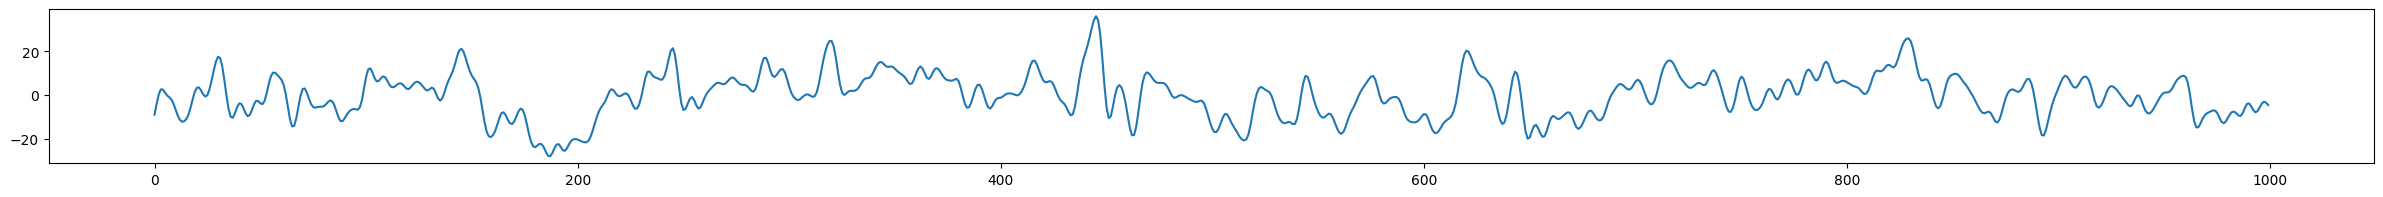

In [37]:

import matplotlib.pyplot as plt

plt.figure(figsize=(30,2))
plt.plot(subject_df["F3"][0:1000])
plt.show()

In [21]:
eeg_data = subject_df[["F3", "F4", "C3", "C4", "class"]]
eeg_data

,F3,F4,C3,C4,class
0,-8.951931,-6.486722,-6.527182,-16.990282,0
1,-4.025522,-0.889648,-0.506992,-7.944988,0
2,0.361466,3.889451,4.043733,1.996416,0
3,2.630152,6.067005,5.338785,8.823297,0
4,2.497307,5.417265,3.714052,10.767968,0
...,...,...,...,...,...
6606595,21.928354,25.154856,4.779032,20.220570,1
6606596,18.767881,23.574886,2.063331,17.738194,1
6606597,15.506461,21.998253,-0.629791,15.470124,1
6606598,12.265061,20.027315,-2.933577,13.321407,1


In [8]:
current_epoch = []
current_class = None
epochs = []

# Iterate through each row in the dataframe
for index, row in eeg_data.iterrows():
    # Check if we're starting a new epoch
    if row['class'] != current_class:
        # If the current epoch list is not empty, store the epoch (limiting to the first 1000 samples)
        if current_epoch:
            epochs.append(pd.DataFrame(current_epoch).head(1000))
            current_epoch = []
        # Update the current class
        current_class = row['class']
    
    # Add the row to the current epoch
    current_epoch.append(row)

# Don't forget to add the last epoch if it exists
if current_epoch:
    epochs.append(pd.DataFrame(current_epoch).head(1000))

# Initialize X and y arrays
X = np.zeros((len(epochs), len(epochs[0].columns)-1, 1000))  # -1 to exclude the class label column
y = np.zeros(len(epochs))

# Populate X and y
for i, epoch in enumerate(epochs):
    # Exclude the last column (class label) for X
    X[i] = epoch.iloc[:, :-1].T  # Transpose to get channels x timestamps format
    # Use the class label for y
    y[i] = epoch['class'].iloc[0]  # All rows have the same class in an epoch, so we take the first


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2616, 4, 1000), (1122, 4, 1000), (2616,), (1122,))

In [26]:
csp = CSP(n_components=2)
csp.fit(X_train, y_train)

Computing rank from data with rank=None


    Using tolerance 25 (2.2e-16 eps * 4 dim * 2.8e+16  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 4 dim * 2.9e+16  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [27]:
X_transfromed = csp.transform(X_train)

In [31]:
X_transfromed.shape

(2616, 2)

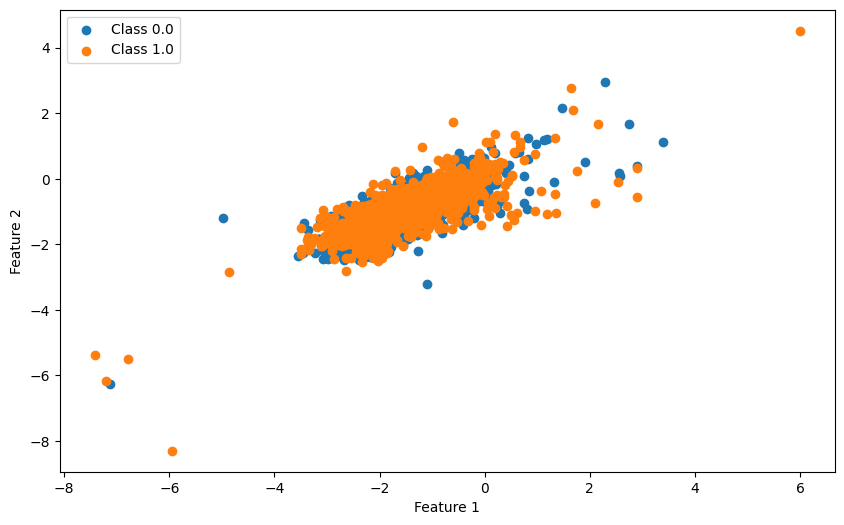

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for i in np.unique(y_train):
    plt.scatter(X_transfromed[y_train == i, 0], X_transfromed[y_train == i, 1], label=f'Class {i}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from joblib import dump
from custom_transformers import FilterBank

# Pipeline setup
pipeline = Pipeline([
    ('filterbank', FilterBank()),
    ('csp', CSP(n_components=4, transform_into='average_power')),
    ('lda', LinearDiscriminantAnalysis())
])

In [17]:
pipeline.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 3.5e+03 (2.2e-16 eps * 20 dim * 7.8e+17  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e+03 (2.2e-16 eps * 20 dim * 7.7e+17  max singular value)
    Estimated rank (mag): 20
    MAG: rank 20 computed from 20 data channels with 0 projectors
Reducing data rank from 20 -> 20
Estimating covariance using EMPIRICAL
Done.


Pipeline(steps=[('filterbank', FilterBank()),
                ('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('lda', LinearDiscriminantAnalysis())])

In [18]:
pipeline.score(X_test, y_test)

0.5098039215686274

In [19]:
dump(pipeline, 'csp_lda_pipeline.joblib')
print("Pipeline saved successfully.")

Pipeline saved successfully.
